In [ ]:
!pip install bertopic langdetect langid pyldavis PyPDF2 pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer

from transformers import pipeline
from transformers import AutoTokenizer
import transformers
import torch
import accelerate

from bertopic import BERTopic

from langdetect import detect
import langid

from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import re
import random
import os

import PyPDF2
import pdfplumber

from sentence_transformers import SentenceTransformer

import zipfile
import requests
import io

from umap import UMAP

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.10/dist-packages/PyPDF2/__init__.py:21: DeprecationWarning: PyPDF2 is deprecated. Please move to the pypdf library instead.
  warnings.warn(


In [ ]:
jpmorgan_q_and_a_file_id = "1XpVrBl_fHjMKxvi-hgCxOnbW7L1bQw52";

r = requests.get('https://drive.google.com/uc?export=download&id=%s' % (jpmorgan_q_and_a_file_id), stream=True)
bytes_io = io.BytesIO(r.content)
zipf = zipfile.ZipFile(bytes_io)

pdf_texts = {}

for item in zipf.namelist():
  if item.endswith('.pdf'):
    f = zipf.open(item)
    identifier = item.split('-')[1]
    identifier_q = identifier.split('q')[0]
    identifier_y = identifier.split('q')[1]
    identifier = identifier_y + 'q' + identifier_q
    with pdfplumber.open(f) as pdf:
      pdf_text = ''.join([page.extract_text() for page in pdf.pages])
    pdf_texts[identifier] = pdf_text

print(pdf_texts.keys())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['19q1', '20q1', '21q1', '22q1', '23q1', '24q1', '19q2', '20q2', '21q2', '22q2', '23q2', '24q2', '19q3', '20q3', '21q3', '22q3', '23q3', '24q3', '19q4', '20q4', '21q4', '22q4', '23q4'])


In [ ]:
def clean_text0(s):
  s = re.split(r'QUESTION AND ANSWER SECTION$', s, flags = re.MULTILINE)[1]
  s = re.split(r'Disclaimer$', s, flags = re.MULTILINE)[0]
  s = re.sub(r'^[0-9]*\.+$', '', s, flags = re.MULTILINE)
  s = re.sub(r'Operator: [\[a-zA-Z \.\'\]]+$', '', s, flags = re.MULTILINE)
  # s = re.split(r'^[0-9]*Important Information$', s, flags = re.MULTILINE)[0]

  s = re.sub(r'[\'\"’]', '\'', s, flags = re.MULTILINE)

  s = re.sub(r'it\'s', 'it is', s, flags = re.MULTILINE)
  s = re.sub(r'\'s', '', s, flags = re.MULTILINE)
  s = re.sub(r'\'ve', ' have', s, flags = re.MULTILINE)
  s = re.sub(r'hasn\'t', 'has not', s, flags = re.MULTILINE)
  s = re.sub(r'didn\'t', 'did not', s, flags = re.MULTILINE)
  s = re.sub(r'don\'t', 'do not', s, flags = re.MULTILINE)
  s = re.sub(r'can\'t', 'can not', s, flags = re.MULTILINE)
  s = re.sub(r'won\'t', 'will not', s, flags = re.MULTILINE)
  s = re.sub(r'wouldn\'t', 'would not', s, flags = re.MULTILINE)
  s = re.sub(r'isn\'t', 'is not', s, flags = re.MULTILINE)
  s = re.sub(r'\'d', ' would', s, flags = re.MULTILINE)
  s = re.sub(r'\'ll', ' will', s, flags = re.MULTILINE)
  s = re.sub(r'\'re', ' are', s, flags = re.MULTILINE)
  s = re.sub(r'\'m', ' am', s, flags = re.MULTILINE)

  # # s = re.sub(r'[^A-Za-z0-9\s]+', '', s, flags = re.MULTILINE);

  # s = s.lower();

  s = re.sub(r'\bquestion\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bquestions\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bthank\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bthanks\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bmeeting\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bbreakfast\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bcall\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\banna\b', '', s, flags = re.MULTILINE)

  s = re.sub(r'\bokay\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bthink\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bwould\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bcould\b', '', s, flags = re.MULTILINE)

  s = re.sub(r'\bus\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\buk\b', '', s, flags = re.MULTILINE)

  s = re.sub(r'\bmorning\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bhi\b', '', s, flags = re.MULTILINE)
  s = re.sub(r'\bhello\b', '', s, flags = re.MULTILINE)

  return s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def extract_question_answer(s):
  p = re.findall(r'^([0-9A-Za-z\.]+ ([\-A-Za-z\.]+)?( [\-A-Za-z\.]+)?( [\-A-Za-z\.]+)?)( [AQ])\n(([A-Za-z]+)( &)?( [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?(, [\-A-Za-z&\.]+)?( [\-A-Za-z&\.]+)?( [\-A-Za-z&\.]+)?( [\-A-Za-z&\.]+)?( [\-A-Za-z&\.]+)?)$', s, flags = re.MULTILINE)
  s = re.split(r'^([0-9A-Za-z\.]+ ([\-A-Za-z\.]+)?( [\-A-Za-z\.]+)?( [\-A-Za-z\.]+)?)( [AQ])\n(([A-Za-z]+)( &)?( [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?(, [\-A-Za-z&\.]+)?( [\-A-Za-z&\.]+)?( [\-A-Za-z&\.]+)?( [\-A-Za-z&\.]+)?( [\-A-Za-z&\.]+)?)$', s, flags = re.MULTILINE)
  # p = re.findall(r'\n([0-9A-Za-z\.]+ ([\-A-Za-z\.]+)?( [\-A-Za-z\.]+)?( [\-A-Za-z\.]+)?)( [AQ])\n(([A-Za-z]+)( &)?( [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?(, [\-A-Za-z&\.\(\)]+)?(,? [\-A-Za-z&\.\(\)]+)?(,? [\-A-Za-z&\.\(\)]+)?(,? [\-A-Za-z&\.\(\)]+)?(,? [\-A-Za-z&\.\(\)]+)?)$', s, flags = re.MULTILINE)
  # s = re.split(r'\n([0-9A-Za-z\.]+ ([\-A-Za-z\.]+)?( [\-A-Za-z\.]+)?( [\-A-Za-z\.]+)?)( [AQ])\n(([A-Za-z]+)( &)?( [A-Za-z]+)?( [A-Za-z]+)?( [A-Za-z]+)?(, [\-A-Za-z&\.\(\)]+)?(,? [\-A-Za-z&\.\(\)]+)?(,? [\-A-Za-z&\.\(\)]+)?(,? [\-A-Za-z&\.\(\)]+)?(,? [\-A-Za-z&\.\(\)]+)?)$', s, flags = re.MULTILINE)
  s = [line for line in s if line is not None]
  s = [line for line in s if (line.startswith('\n') and line.endswith('\n') and len(line.replace('\n', '')) > 0)]
  q_or_a = [pp[4] for pp in p]
  p = [[pp[0], pp[5]] for pp in p]
  full_s = s
  s = [re.sub(r'[^A-Za-z\s]+', '', ss, flags = re.MULTILINE) for ss in s]
  s = [re.sub(r'\n', ' ', ss, flags = re.MULTILINE) for ss in s]
  s = [ss.lower() for ss in s]

  stop_words = set(stopwords.words('english'))

  clean_s = []

  for ss in s:
    word_tokens = word_tokenize(ss)
    filtered = [w for w in word_tokens if not w in stop_words]
    filtered = [word for word in filtered if len(word) > 1]
    filtered = [word for word in filtered if word.find('bank') < 0]
    filtered = [word for word in filtered if word.find('banking') < 0]
    filtered = [word for word in filtered if word.find('uk') < 0]
    filtered = [word for word in filtered if word.find('morgan') < 0]
    filtered = [word for word in filtered if word.find('jp') < 0]
    filtered = [word for word in filtered if not word in ['yes', 'sorry', 'okay', 'hi', 'thank', 'thanks', 'much', 'got', 'hear', 'yeah', 'yup', 'yeap']]
    filtered = [word for word in filtered if not word in ['first', 'second', 'next', 'welcome', 'hello']]
    filtered = [word for word in filtered if not word in ['operator', 'line']]
    filtered = [word for word in filtered if not word in ['fair', 'lot', 'please', 'proceed', 'agree', 'disagree', 'guess', 'quick', 'followup', 'couple', 'fair', 'enough']]
    filtered = [word for word in filtered if not word in ['good', 'oh', 'appreciate', 'sure', 'awesome', 'excellent', 'understood', 'ahead', 'go', 'alright']]
    filtered = [word for word in filtered if not word in ['helpful', 'great', 'hey', 'follow', 'one', 'back', 'got', 'hear', 'yeah', 'right', 'hope']]
    filtered = [word for word in filtered if not word in ['john', 'mike', 'steven', 'gerard', 'betsy', 'glenn', 'steve', 'jamie', 'jennifer', 'jim', 'jenn', 'jeremy', 'erika']]
    filtered = [word for word in filtered if not word in ['matt', 'fargo', 'wells', 'mayo', 'oconnor', 'analyst', 'securities', 'inc']]
    filtered = [word for word in filtered if not word in ['saul', 'martinez', 'hsbc', 'usa', 'schorr', 'everyone', 'evercore']]
    filtered = [word for word in filtered if not word in ['chubak', 'mayo', 'wolfe', 'poonwala', 'ebrahim', 'mcdonald', 'wells']]
    filtered = [word for word in filtered if not word in ['james', 'mitchell', 'buckingham', 'research', 'group', 'marianne']]
    filtered = [word for word in filtered if not word in ['barnum', 'chief', 'financial', 'officer', 'chase', 'co', 'memberoperating', 'committee']]
    filtered = [word for word in filtered if not word in ['ken', 'usdin', 'jefferies', 'may', 'open']]
    filtered = [word for word in filtered if not word in ['poonawala', 'bofa', 'najarian', 'bofa', 'ubs']]
    filtered = [word for word in filtered if not word in ['coming', 'autonomous', 'isi', 'deutsche']]
    filtered = [word for word in filtered if not word in ['cassidy', 'rbc', 'stanley', 'morgan']]
    filtered = [word for word in filtered if not word in ['mean', 'sort', 'kind', 'number', 'like', 'look', 'actually']]
    filtered = [word for word in filtered if not word in ['taking', 'comp', 'fingers', 'exactly', 'graseck', 'ltv', 'jump', 'matthew', 'oversimplifying', 'want']]
    filtered = [word for word in filtered if not word in ['andrew', 'lim', 'socit', 'gnrale', 'sa', 'hawaii', 'lake']]
    filtered = [word for word in filtered if not word in ['million', 'billion', 'i', 'ii', 'iii', 'iv']]
    filtered = [word for word in filtered if not word in ['bye', 'marks', 'end', 'conference', 'today', 'disconnect', 'joining', 'enjoy', 'rest', 'day', 'folks', 'everybody', 'talking']]
    filtered = [word for word in filtered if not word in ['answer', 'expected', 'going', 'give', 'wanted', 'give', 'answer', 'say', 'aware', 'nevertheless', 'quite', 'detailed', 'indiscernible', 'derek', 'nonperforming']]
    filtered = [word for word in filtered if not word in ['know', 'bit', 'requeue', 'perfect', 'little', 'see', 'let', 'possible', 'outcome', 'meaningful']]
    filtered = [word for word in filtered if not word in ['concludes', 'years', 'volcker', 'conclusion', 'tell', 'stand', 'morning', 'pointing', 'well', 'unlikely']]
    filtered = [word for word in filtered if not word in ['whatever', 'probably', 'muchthere', 'eighteen', 'different', 'things']]
    filtered = [word for word in filtered if not word in ['another', 'part', 'forgot', 'yet', 'details', 'make', 'point', 'important']]
    filtered = [word for word in filtered if not word in ['color', 'add', 'quarter', 'gosh', 'reggie', 'guys', 'maybe', 'clear']]
    filtered = [word for word in filtered if not word in ['happens', 'hit', 'changing', 'wait', 'way', 'simple', 'forward', 'either', 'dashboard', 'shocked']]
    filtered = [word for word in filtered if not word in ['win', 'still', 'ok', 'dont', 'wherever', 'isnt', 'lbo', 'mitate', 'messaging', 'okeydokey']]
    filtered = [word for word in filtered if not word in ['reason', 'imitate', 'pray', 'serendipity', 'standby', 'even', 'interesting', 'everything', 'indeed', 'technically']]
    filtered = [word for word in filtered if not word in ['models', 'expecting', 'tidy', 'hop', 'issue', 'catch', 'nerd', 'distracted', 'queue', 'sufficient']]
    filtered = [word for word in filtered if not word in ['weights', 'changer', 'fun', 'sound', 'simplify', 'resolved', 'imminent', 'reading', 'rd', 'qs']]
    filtered = [word for word in filtered if not word in ['year', 'said', 'writedown', 'noticing', 'party', 'lastly', 'camp', 'intent', 'modestly', 'listen']]
    filtered = [word for word in filtered if not word in ['flip', 'last', 'time', 'wasnt', 'obviously', 'series', 'accordingly', 'emphasize', 'opinion', 'ready']]
    clean_s.append(' '.join(filtered))

  return p, q_or_a, clean_s, full_s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pdf_q_and_a = {}
for pdf_key, pdf_text in pdf_texts.items():
  s = clean_text0(pdf_texts[pdf_key])
  p, q_or_a, s, full_s = extract_question_answer(s)
  pdf_q_and_a[pdf_key] = [p, q_or_a, s, full_s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_q_and_as = pd.DataFrame(columns=['Quarter', 'PersonQ', 'AffiliationQ', 'PersonA', 'AffiliationA', 'TextQ', 'TextA', 'FullTextQ', 'FullTextA'])

for pdf_key, q_and_a in pdf_q_and_a.items():
  p, q_or_a, s, full_s = q_and_a
  # if not pdf_key.startswith("24q3"):
  #   continue
  # print(pdf_key)
  # p_answering = []
  # for i in range(len(p)):
  #   person = p[i][0].replace(', ', '') if len(p[i][0]) > 0 else ''
  #   affiliation = p[i][1].replace(', ', '') if len(p[i][1]) > 0 else ''
  #   person = person.lower()
  #   affiliation = affiliation.lower()
  #   if affiliation.startswith('group') or person in ['anna cross']:
  #     p_answering.append(person)
  for i in range(int(np.min([len(s), len(p)]))):
    person = p[i][0].replace(', ', ' ')
    affiliation = p[i][1].replace(', ', ' ')
    is_q_or_a = q_or_a[i].startswith(' Q')
    text = s[i]
    text = text.split(' ')
    token_count = 50
    text = [' '.join(text[i:i + token_count]) for i in range(0, len(text), token_count)]
    text = [line for line in text if len(line) > 0]
    full_text = full_s[i]
    full_text = full_text.split(' ')
    token_count = 50
    full_text = [' '.join(full_text[i:i + token_count]) for i in range(0, len(full_text), token_count)]
    full_text = [line for line in full_text if len(line) > 0]
    # print(person, affiliation, text, is_q_or_a)
    # print(person)
    # print(affiliation)
    # print(q_or_a)
    if is_q_or_a:
      df_q_and_as.loc[df_q_and_as.shape[0]] = [pdf_key, person, affiliation, '', '', text, '', full_text, '']
    else:
      iloc_q = df_q_and_as.shape[0]-1
      df_q_and_as.loc[iloc_q].PersonA = person
      df_q_and_as.loc[iloc_q].AffiliationA = affiliation
      text_a = df_q_and_as.iloc[iloc_q].TextA
      full_text_a = df_q_and_as.iloc[iloc_q].FullTextA
      text.extend(text_a)
      full_text.extend(full_text_a)
      df_q_and_as.loc[iloc_q].TextA = text
      df_q_and_as.loc[iloc_q].FullTextA = full_text

df_q_and_as = df_q_and_as.sort_values(by=['Quarter'])

df_q_and_as.to_csv('JPMorgan_q_and_a.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_q_and_as

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Quarter,PersonQ,AffiliationQ,PersonA,AffiliationA,TextQ,TextA,FullTextQ,FullTextA
0,19q1,John Eamon McDonald,Analyst Autonomous Research,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[expense control letter show goals improving efficiency ratio main business units wondering driving cresting investment spend occur positive operating leverage carrying],[big picture combination talked investor fact always net incremental investment decision based merits total amount spending amount dollars roll every get repositioned investment feel net investmen...,"[\nHi. Good . Marianne, you had good expense control this quarter and, Jamie letter, you show goals of improving the efficiency ratio in\neach of the main business units for the next few years. Ju...","[\nYeah. Hey, John. So, I say, just big picture is a combination of both, obviously. We talked at Investor Day about the fact that we are\nalways going to make the net incremental investment deci..."
20,19q1,Alevizos Alevizakos,Analyst HSBC Bank Plc,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[basically treasury services yearonyear growth double digit grew apparently volumes remained healthy margins started deteriorate wonder feel remaining especially given trade talks ongoing therefor...,[treasury services revenue growth double digits yearon mentioned earlier wholesale businesses happen basis compression funding spreads provide businesses pricing declines given rates moved headwin...,"[\nHi. I have got a quick and a follow-up basically. My is on the Treasury Services. Year-on-year the growth going from double-\ndigit you just grew to 3%, where apparently the volumes remained ...","[\nYes. Okay. So, first point on Treasury Services, obviously, last year revenue growth was in double digits, for this year quarter, 3% year-on-\nyear. I mentioned earlier that for both of our Who..."
21,19q1,Alevizos Alevizakos,Analyst HSBC Bank Plc,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[],[spoke recently six weeks ago overall really patient fed turns central dovish generally constructive environment credit risk balance sheet curve flatter compelling situation duration natural risk ...,[\nThank you very much.\n\n],"[\nWell, so, we only spoke to you most recently, about six weeks ago, so the sort of overall answer is no, not really. We expected at that point\nthat we have a patient Fed. It turns out that all..."
22,19q1,Erika Najarian,Analyst Bank of America Merrill Lynch,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[comment backdrop lower rates longer sense thinking deposit strategy retail wholesale words discussed dynamics pricing expect competition taper room lower deposit costs rate curve stays prolonged ...,[put big contextual always strategy around deposits deposit pricing driven observing consumer behaviors seeing deposit flows environment determine happening seen naturally course rates rising seen...,"[\nYes. Hi. Good . I just wanted to follow-up, Marianne, on the comment. In the backdrop for lower rates for longer, you give a\nsense on how you are thinking about your deposit strategy in reta...","[\nSo, I will just put – the big contextual answer will always be the same, which is when we about our strategy around deposits and deposit\npricing, it is 100% driven by what we are observing in..."
23,19q1,Erika Najarian,Analyst Bank of America Merrill Lynch,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[heard loud prepared remarks increase wholesale non accruals idiosyncratic wondering tickup nonaccrual loans corporate investment past two quarters cycle growing low base expect stepdown nonaccrua...,[situations expect present feature extremely low base movement whether somewhat exaggerated continue credit environment benign],[\nThank you. And my follow-up is we heard you loud and clear during your prepared remarks that the increase in Wholesale non-\naccruals was idiosyncratic. And I am wondering as we look at a tick...,"[\nThere

In [ ]:
umap = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=0)

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df_q_and_as.Quarter.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['19q1', '19q2', '19q3', '19q4', '20q1', '20q2', '20q3', '20q4',
       '21q1', '21q2', '21q3', '21q4', '22q1', '22q2', '22q3', '22q4',
       '23q1', '23q2', '23q3', '23q4', '24q1', '24q2', '24q3'],
      dtype=object)

In [ ]:
# [(df_q_and_as.Quarter == '20200731') | (df_q_and_as.Quarter == '20200507')]

text_q = df_q_and_as.TextQ.values
text_a = df_q_and_as.TextA.values

text_q = [line for list_of_lines in text_q for line in list_of_lines]
text_a = [line for list_of_lines in text_a for line in list_of_lines]

text = text_q
text.extend(text_a)

topic_model.fit(text)
topic, probabilities = topic_model.transform(text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pd.set_option('display.max_colwidth', None)

topic_model.merge_topics(text, [[-1, 11], [-1, 19], [-1, 22]])
topic, probabilities = topic_model.transform(text)

topic_info = topic_model.get_topic_info()
topic_info.to_csv('JPMorgan_topics.csv', index=False)
topic_info

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,834,-1_capital_get_really_terms,"[capital, get, really, terms, rates, people, growth, market, rate, business]","[investment portfolio managing balance sheet rate environment dynamic lower rates deposit growth mentioned audio gap fed balance sheet expansion large increase investment portfolio makes sense terms balance sheet management completely focused supporting client activity balance sheet harder predict prepared range outcomes, deposits driven fed balance sheet extent lending given demand picture near term driven fed balance sheet expansion continue expect significant deposit growth terms deploy seen cash balances quarteroverquarter remember patient investment portfolio true also mention steepening yield curve less short drift long selloff dynamic shortterm cash deployment also saw repo, come investment balances terms balance sheet growth largely deposits example rate environment economy matter whole declining rate environment higher yielding alternatives consumers less attractive expect continue grow franchise healthy growth deposit base referring terms investment increase earlier buy duration importantly investment also cash deployment strategies actions took mortgage loan sales]"
1,0,88,0_expense_expenses_revenue_investment,"[expense, expenses, revenue, investment, volume, environment, revenuerelated, efficiency, spend, outlook]","[example wound wrong type environment budgeting expect significant drop volume revenuerelated expense current outlook contribute operating leverage always generating efficiency worked hard whether revenue environment bad invest cycle broadly investment plans really shouldnt sensitive shortterm changes environment course certain types marketing investments card business particular math expect npv cycle change, efficiency ratio run company discipline whether relentlessly pursuing expense efficiencies investing discipline cycle efficiency ratio input expenses revenue target operating leverage always change run company temporary revenue headwinds expenses investor told cost curve flatten post adjusted expenses expect less, increase guidance gave almost entirely volume revenuerelated volume revenuerelated example volumes ccb given environment valuable longterm franchise revenue growth revenue growth near term always manage place expenses associated volume growth revenue growth anticipate long run almost entirely volume revenuerelated marketing expense given strength recovery expect expect lean marketing expense half]"
2,1,84,1_nii_deposit_curve_markets,"[nii, deposit, curve, markets, betas, rate, rates, outlook, ex, beta]","[highlighted full nii guidance implies sizable drop nii ex markets discuss largest drivers sequential decline including initial thoughts deposit behavior pricing since basis cut since related throw realize curve moving around since dan brought month ago frame thinking nii trajectory, absolutely true markets businesses run nii versus noninterest revenue accounting construct markets particularly true nii markets business liability sensitive benefit lower rates nii doesnt necessarily imply anything overall performance, unpack higher longer rate possibility impacts nii nii guide assuming curve understand correctly event get higher longer impact nii ex markets trying triangulate lose deposits higher longer shouldnt expect trajectory goes opposed]"
3,2,79,2_credit_private_commercial_estate,"[credit, private, commercial, estate, overearning, lending, real, consumer, reserve, portfolio]","[overdoing pressures industry growth united states better credit extraordinarily consumer credit commercial credit wholesale extraordinarily get worse cycle always try plan cycle overearning cycle credit underearning credit course recession affects volumes cycle bad, analysis capabilities really increasingly private credit space gets bigger starts sense bring colenders big deals without undue concentration risks capital concentration risk funny 

In [ ]:
topic_model.visualize_barchart(top_n_topics=40).show(renderer="colab")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(text)

hierarchical_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100%|██████████| 33/33 [00:00<00:00, 156.48it/s]


,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
32,66,growth_nii_capital_really_get,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]",60,capital_gsib_basel_buybacks_scb,65,growth_nii_rate_outlook_card,1.334335
31,65,growth_nii_rate_outlook_card,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33]",64,growth_credit_card_people_consumer,61,nii_deposit_deposits_curve_rate,1.262310
30,64,growth_credit_card_people_consumer,"[0, 2, 3, 4, 5, 6, 8, 10, 13, 14, 15, 17, 22, 24, 26, 27, 29, 30, 32, 33]",62,data_stuff_cloud_people_digital,63,credit_growth_card_loan_case,1.130082
29,63,credit_growth_card_loan_case,"[0, 2, 4, 6, 8, 10, 13, 14, 15, 17, 33]",59,case_base_unemployment_cecl_scenarios,54,card_credit_growth_loan_expense,1.059419
28,62,data_stuff_cloud_people_digital,"[3, 5, 22, 24, 26, 27, 29, 30, 32]",58,data_stuff_cloud_digital_ai,55,market_markets_competition_share_products,1.028027
27,61,nii_deposit_deposits_curve_rate,"[1, 9, 11, 16, 21, 28, 31]",42,nii_curve_sheet_rates_duration,47,deposits_deposit_qt_cd_rrp,0.982880
26,60,capital_gsib_basel_buybacks_scb,"[7, 12, 18, 19, 20, 23, 25]",46,gsib_basel_capital_scb_buffer,51,capital_buybacks_dividend_buyback_stock,0.932422
25,59,case_base_unemployment_cecl_scenarios,"[4, 8, 10, 15, 33]",39,case_base_unemployment_cecl_scenarios,45,inflation_consumer_shape_economy_recession,0.924077
24,58,data_stuff_cloud_digital_ai,"[3, 5, 22, 24, 30, 32]",53,data_cloud_ai_stuff_digital,57,branches_help_states_government_people,0.916813
23,57,branches_help_states_government_people,"[22, 24, 30]",30,branches_branch_expansion_states_new,56,help_government_people_try_hospitals,0.893269


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, width=1600, height=1000, title='JPMorgan Q&A topic groups').show(renderer="colab")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

picked_topic_cluster_names = ['capital_gsib_basel_buybacks_scb', 'data_stuff_cloud_digital_ai', 'market_markets_competition_share_products', 'case_base_unemployment_cecl_scenarios', 'card_credit_growth_loan_expense', 'nii_deposit_deposits_curve_rate']

picked_topic_cluster_ids = [hierarchical_topics[hierarchical_topics['Parent_Name'] == picked_topic_cluster_name].Parent_ID.values[0] for picked_topic_cluster_name in picked_topic_cluster_names]

picked_topic_cluster_keywords = [topic_info[topic_info['Topic'].isin(hierarchical_topics[hierarchical_topics['Parent_ID'] == picked_topic_cluster_id].Topics.values[0])].Representation.values for picked_topic_cluster_id in picked_topic_cluster_ids]

picked_topic_ids = [topic_info[topic_info['Topic'].isin(hierarchical_topics[hierarchical_topics['Parent_ID'] == picked_topic_cluster_id].Topics.values[0])].Topic.values for picked_topic_cluster_id in picked_topic_cluster_ids]

picked_topic_clusters = pd.DataFrame(columns=['Cluster_ID', 'Topic_cluster_name', 'Topics', 'Keywords'])

for i in range(len(picked_topic_cluster_names)):
  picked_topic_clusters.loc[picked_topic_clusters.shape[0]] = [picked_topic_cluster_ids[i], picked_topic_cluster_names[i], picked_topic_ids[i], picked_topic_cluster_keywords[i]]

picked_topic_clusters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Cluster_ID,Topic_cluster_name,Topics,Keywords
0,60,capital_gsib_basel_buybacks_scb,"[7, 12, 18, 19, 20, 23, 25]","[[gsib, scb, recalibration, bucket, target, gs..."
1,58,data_stuff_cloud_digital_ai,"[3, 5, 22, 24, 30, 32]","[[digital, fintech, travel, clients, customers..."
2,55,market_markets_competition_share_products,"[26, 27, 29]","[[competition, market, share, markets, private..."
3,59,case_base_unemployment_cecl_scenarios,"[4, 8, 10, 15, 33]","[[case, base, unemployment, scenarios, adverse..."
4,54,card_credit_growth_loan_expense,"[0, 2, 6, 13, 14, 17]","[[expense, expenses, revenue, investment, volu..."
5,61,nii_deposit_deposits_curve_rate,"[1, 9, 11, 16, 21, 28, 31]","[[nii, deposit, curve, markets, betas, rate, r..."


In [ ]:
text_q = df_q_and_as.TextQ.values
text_a = df_q_and_as.TextA.values

# topic_info = [' '.join([topic_info[topic_info.Topic == topic_i].Name.values[0], str(topic_info[topic_info.Topic == topic_i].Representation.values[0])]) for topic_i in topic]
topic_info_list = [topic_info[topic_info.Topic == topic_i].Name.values[0] for topic_i in topic]

topic_info_per_q = []
topic_info_per_a = []

last_topic_i = 0
for i in range(len(text_q)):
  info_per_q = topic_info_list[last_topic_i:last_topic_i+len(text_q[i])]
  topic_info_per_q.append(info_per_q)
  last_topic_i = last_topic_i+len(text_q[i])

# last_topic_i = 0
for i in range(len(text_a)):
  info_per_a = topic_info_list[last_topic_i:last_topic_i+len(text_a[i])]
  topic_info_per_a.append(info_per_a)
  last_topic_i = last_topic_i+len(text_a[i])

topic_info_per_q = [list(set(topic_list)) for topic_list in topic_info_per_q]
df_q_and_as['TopicQ'] = topic_info_per_q

topic_info_per_a = [list(set(topic_list)) for topic_list in topic_info_per_a]
df_q_and_as['TopicA'] = topic_info_per_a

df_q_and_as = df_q_and_as.sort_values(by=['Quarter'])

df_q_and_as.to_csv('JPMorgan_q_and_a_with_topics.csv', index=False)

df_q_and_as

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Quarter,PersonQ,AffiliationQ,PersonA,AffiliationA,TextQ,TextA,FullTextQ,FullTextA,TopicQ,TopicA
0,19q1,John Eamon McDonald,Analyst Autonomous Research,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[expense control letter show goals improving e...,[big picture combination talked investor fact ...,"[\nHi. Good . Marianne, you had good expense c...","[\nYeah. Hey, John. So, I say, just big pictu...",[0_expense_expenses_revenue_investment],"[-1_capital_get_really_terms, 0_expense_expens..."
1,19q1,John Eamon McDonald,Analyst Autonomous Research,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[nii outlook reassuring able hold investor out...,[thing seen periods get shortterm fluctuations...,"[\nOkay. And then just on the NII outlook, it ...","[\nYeah. So, the first thing I say is that we...",[1_nii_deposit_curve_markets],[-1_capital_get_really_terms]
3,19q1,Mike Mayo,Analyst Wells Fargo Securities LLC,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[deposit growth due digital quantify ballpark ...,[deposit growth remember also investment asset...,[\nSo how much of the deposit growth is due to...,"[\nWell, I can tell you that – and so it is no...",[9_deposits_deposit_share_growth],[30_branches_branch_expansion_states]
4,19q1,Glenn Schorr,Analyst Evercore ISI,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[sec sic services heard loud funding basis com...,[business exit feature always yearoveryear fee...,[\nHi. Thanks very much. On Sec (sic) [Securit...,"[\n5Yes. So, on the business exit, this is – i...",[-1_capital_get_really_terms],"[-1_capital_get_really_terms, 0_expense_expens..."
5,19q1,Glenn Schorr,Analyst Evercore ISI,Marianne Lake,Chief Financial Officer JPMorgan Chase & Co.,[],[comment digital space digital assets digital ...,[\n[indiscernible] (24:32)\n\n],[\nCan I just – I am sorry. Can I just make on...,[],[3_digital_fintech_travel_clients]
...,...,...,...,...,...,...,...,...,...,...,...
576,24q3,Betsy L. Graseck,Analyst Morgan Stanley & Co. LLC,Jamie Dimon,Chairman & Chief Executive Officer JPMorgan Ch...,[asset acquisitions always people looking thin...,[loans apple card],"[\nYeah. So asset acquisitions, I mean I alway...",[\nWhat about loans? The Apple card…\n\n],[2_credit_private_commercial_estate],[17_mortgage_mortgages_servicing_margin]
564,24q3,Mike Mayo,Analyst Wells Fargo Securities LLC,Jamie Dimon,Chairman & Chief Executive Officer JPMorgan Ch...,[wrong always american patriot country company...,[asked administration serve country considering],[\nI it is wrong. I have always been an Ameri...,[\nSo if you were asked by the next administra...,[22_help_government_try_people],[22_help_government_try_people]
571,24q3,Betsy L. Graseck,Analyst Morgan Stanley & Co. LLC,Jeremy Barnum,Chief Financial Officer JPMorgan Chase & Co.,[],[],[\nYeah.\n\n],[\nCan you hear me ?\n\n],[],[]
572,24q3,Betsy L. Graseck,Analyst Morgan Stanley & Co. LLC,Jeremy Barnum,Chief Financial Officer JPMorgan Chase & Co.,[],[nii half revenue care thinking trough buildup...,[\nYeah. We can hear you. Can you hear ?\n\n],"[\nOh, yes. Thank you. So one for Jeremy, one ...",[],[-1_capital_get_really_terms]


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df_q_and_as_topic_special = df_q_and_as[['5_cloud_data_ai_stuff' in topic for topic in df_q_and_as['TopicQ'].values]]
df_q_and_as_topic_special[['Quarter', 'FullTextQ', 'FullTextA']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Quarter,FullTextQ,FullTextA
195,19q2,"[\nYeah. Look, it is amazing, our fraud costs with all the things going on in the world today are down because of effectively for the AI and big data\nand stuff like that. And so it is hard to compete in that. And with You Invest, you look at our client, investment assets grew 16%, a portion of it is\nYou Invest and obviously You Invest costs hundreds of millions of dollars to build. So, you have got to put all these things in perspective about\nhow you try to make the decision going forward.\n\n]","[\nAnd then follow-up, Jamie, you mentioned the environment and all the things taking place in the world, how is the environment now? I mean,\non the one hand, you have trade war, you have lower interest rates, you have capital markets which are down for the big banks, you have a, lot\nof pessimism. On the other hand, you highlighted your results. When you take the temperature of the environment, what the temperature?\n\n]"
401,19q3,"[\nAll right. Let me have one follow-up then. So, I mean, how many center personnel do you have or how many data centers do you have?\nAnd how does that compare to the peak?\n\n]","[\nYeah. And with all the cyber stuff you read about, our fraud in Card and consumer has come down, not gone up, because of some of these\ndeployed technologies in centers, right, I will not take you through all of them, because then we are telling the bad guys our, secrets, but there\nare lot of ways to stop some of the bad guys now.\n\n\n\n, \nYes. I like to do that. And then on centers, Mike, we do not necessarily about it just in terms of number of people. We about the\nproductivity of the people, so the number of calls that they are able to take because you may have more, people because of more volume, but\n7that good, healthy volume with top line growth. But we are always making sure that the people in our centers and the overall productivity\nof the center is increasing.\n\n, \nWe are building brand-new data centers as we speak. I forgot the total number, but there quite a few. The new ones being better and more\nefficient and more expandable and safer, more secure, all that kind of stuff. And we have to build that infrastructure to have the best in, the\nworld. So we are not going to ever scrimp on something like that. And maybe at Investor Day we go a little bit more into how we try to\nmanage the technology budget.\n\n]"
603,19q4,"[\nHello there. Hi. Quick on open APIs and what the big picture is here and how it impacts you and the rest of the banking industry,\nmeaning there concerns over data security and things like that, but JPMorgan has some – plenty of agreements with some of the bigger\nproviders. So,, I am just curious to get your big picture thoughts on what level of concerns should we have, what the good and the bad?\n\n]","[\nThat a great point. And we are going to make it super easy for our customers to be able to do that.\n, \nBut, very importantly, is that that data is the data the customer agrees to give them on the basis they agree to give it to them. So it is not\nunlimited access to customer data, and the customer will have the ability to turn it off, as opposed to today, if, you gave your bank pass code to\nsomeone, they are taking your data every day, maybe even every minute, and you do not even know about it because you forgot.\n, \nYeah. There, I say, Glenn, our customers' data privacy and security is of utmost importance to . And we , over time, the best way\nfor to do that as securely as we can is to have third-party apps only access data through our APIs. And so, we are, working name by name\nto get those agreements in place, and we hope through time that is exclusively the only way that third parties can access our customers' data.\nWe that the most secure way to do it.\n\n]"
618,20q4,"[\nOkay. And then the follow-up just on the technology budget increasing. I mean, I know this comes after a year of being somewhat\nstable year-on-year. And just wanted

In [ ]:
topic_info = topic_model.get_topic_info()

topics_per_q = pd.DataFrame(index=df_q_and_as.Quarter.unique(), columns=topic_info.Name.unique())
column_names = dict(zip(topic_info.Name.unique(), [topic.split('_')[0] for topic in topic_info.Name.unique()]))

for index, row in df_q_and_as.iterrows():
  topics_row_a = row.TopicA
  topics_row_q = row.TopicQ
  for topic_row_a in topics_row_a:
    topics_per_q.at[row.Quarter, topic_row_a] = topics_per_q.at[row.Quarter, topic_row_a] + 1 if not np.isnan(topics_per_q.at[row.Quarter, topic_row_a]) else 1

topics_per_q.rename(columns=column_names, inplace=True)

topics_per_q['Quarter'] = df_q_and_as.Quarter.unique()

topics_per_q.replace(np.nan, 0, inplace=True)

topics_per_q.drop(columns=[topics_per_q.columns[0]], inplace=True)

topics_per_q.to_csv('JPMorgan_topics_per_quarter.csv', index=True)

topics_per_q

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,Quarter
19q1,3,0,2,2,0,2,1,0,1,1,1,0,0,0,0,1,2,2,0,1,1,1,0,0,0,0,0,2,0,2,3,1,0,0,19q1
19q2,0,2,0,3,1,2,1,0,1,1,2,2,0,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,19q2
19q3,1,1,2,1,0,2,0,2,1,0,0,2,0,1,0,0,1,1,0,2,0,0,3,0,0,0,0,2,0,0,1,1,0,0,19q3
19q4,4,1,1,0,1,3,1,0,2,0,0,0,1,0,0,1,0,0,0,0,2,0,0,0,0,1,2,1,0,0,0,0,0,0,19q4
20q1,1,0,1,1,3,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,20q1
20q2,0,0,4,0,6,0,1,1,2,2,2,2,0,1,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,20q2
20q3,3,1,3,0,3,0,1,1,2,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,20q3
20q4,4,1,0,8,0,3,1,1,2,2,0,0,0,2,1,0,0,1,1,0,0,0,2,0,4,1,0,1,2,0,2,0,2,1,20q4
21q1,2,1,0,2,0,2,1,3,1,2,1,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,21q1
21q2,4,3,0,4,0,1,0,2,0,0,1,2,1,0,2,2,2,1,1,0,0,1,0,1,1,2,1,0,0,0,0,0,0,0,21q2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



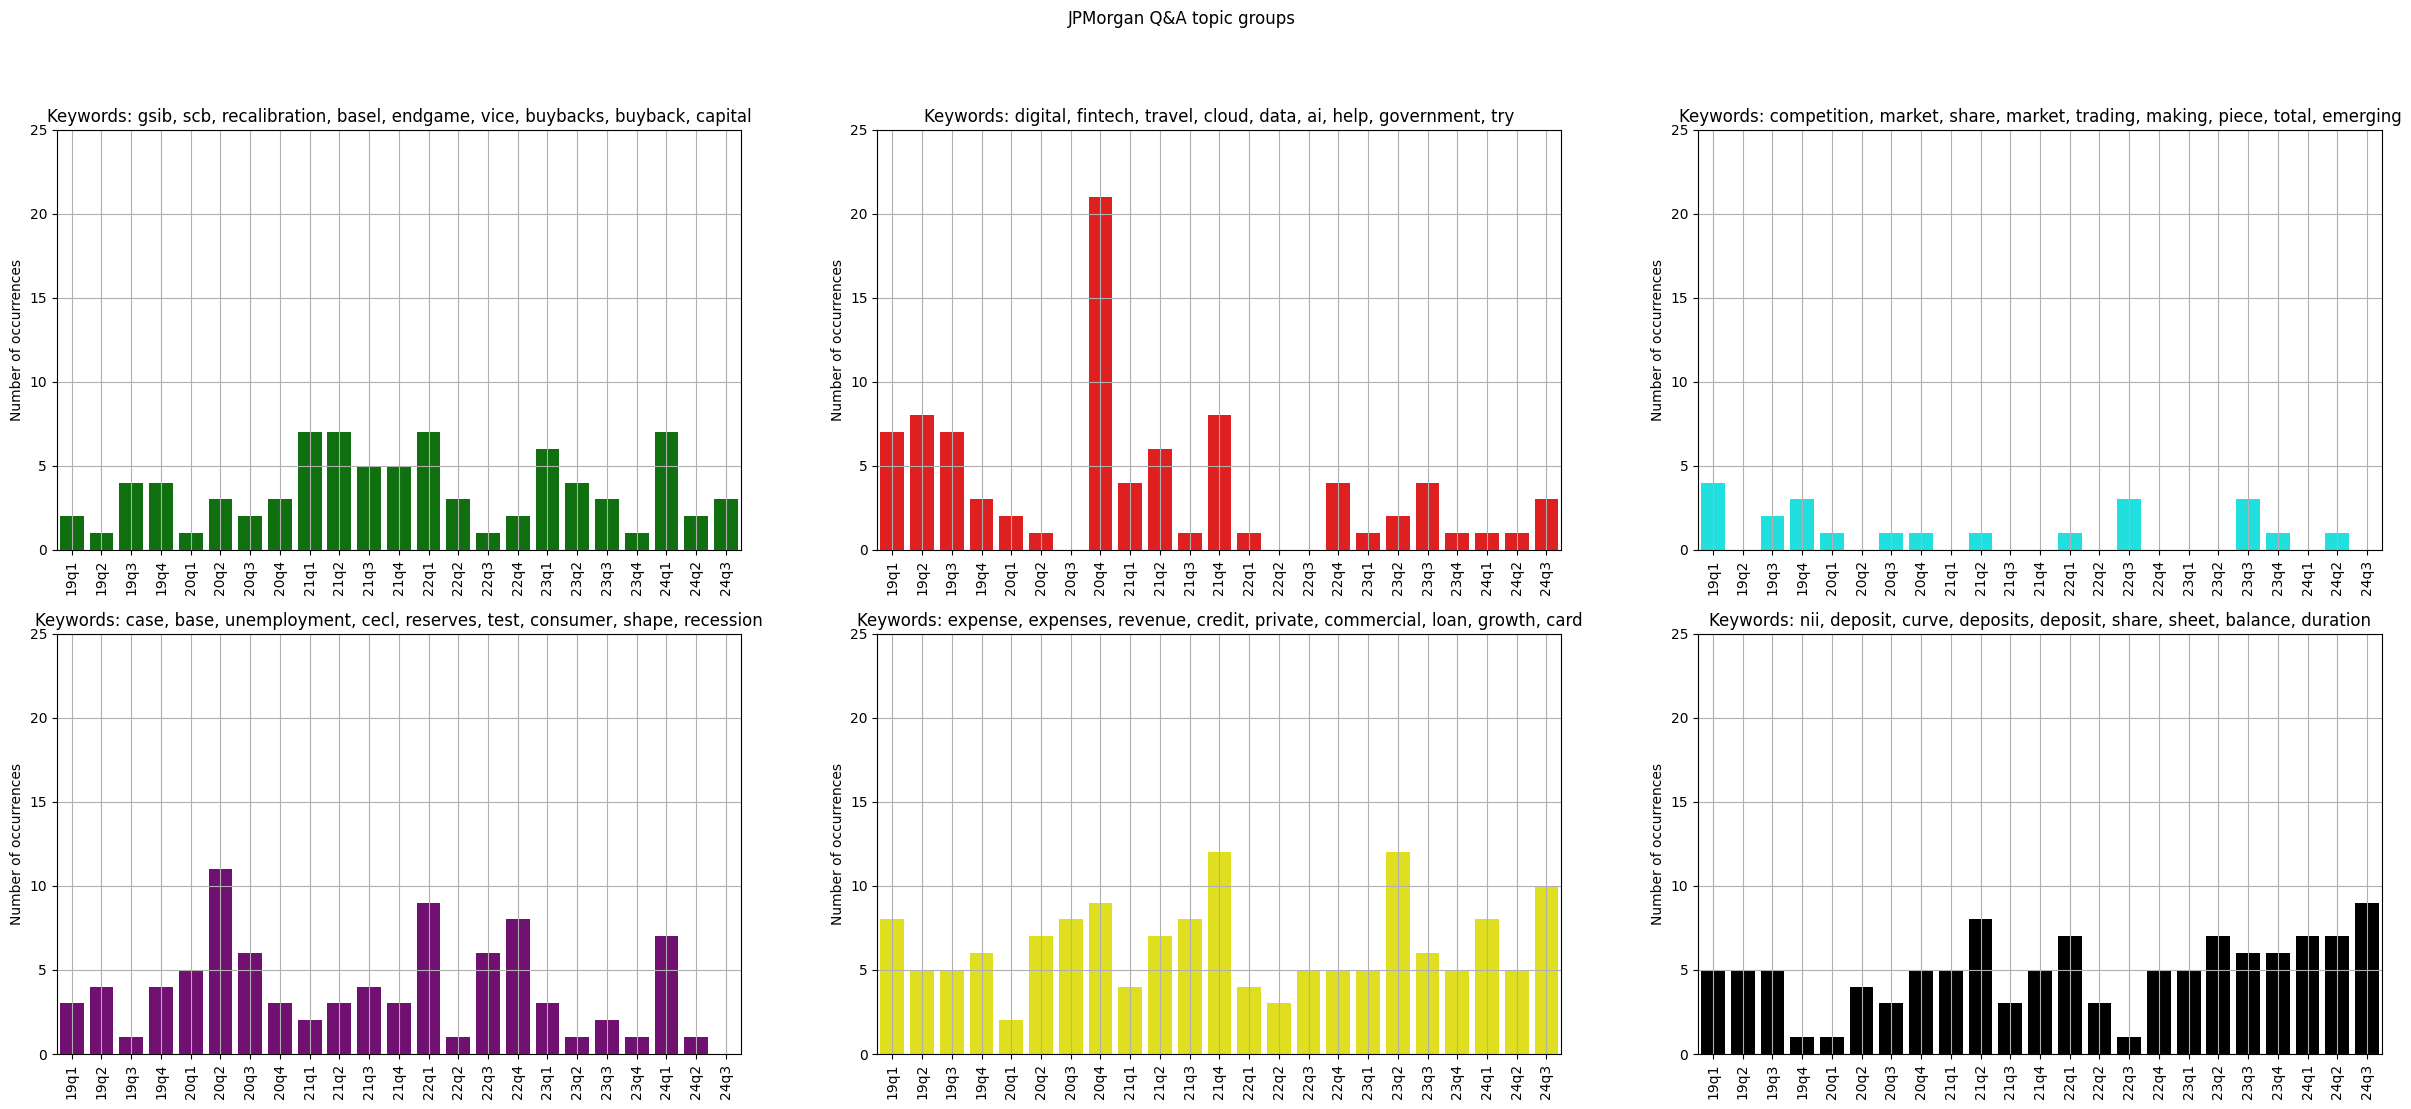

In [ ]:
topic_clusters = []
for cluster_id in picked_topic_cluster_ids:
  topic_clusters.append([hierarchical_topics[hierarchical_topics['Parent_ID'] == cluster_id].Topics.values[0]])

plt.figure(figsize=(30, 12))
plt.rcParams.update({'font.size': 10})
colors = ['green', 'red', 'cyan', 'purple', 'yellow', 'black']

# print(picked_topic_cluster_keywords)
topic_keywords = [', '.join([', '.join(topic_keyword[0:3]) for topic_keyword in topic_keywords[0:3]]) for topic_keywords in picked_topic_cluster_keywords]

p = 1
num_rows = 2
for i in range(len(topic_clusters)):

  topic_cluster = [str(topic_id) for topic_id in topic_clusters[i][0]]
  # print(topic_cluster)
  values = topics_per_q[topic_cluster].sum(axis=1)

  plt.subplot(num_rows,int(np.ceil(len(topic_clusters)/num_rows)),p)
  sns.barplot(x="Quarter", y=values, data=topics_per_q, color=colors[(p-1)%len(colors)])
  plt.title('Keywords: ' + topic_keywords[i])
  plt.xticks(rotation=90)
  plt.ylabel("Number of occurrences")
  plt.xlabel("")
  plt.grid()
  plt.ylim([0, 25])
  p = p + 1

plt.suptitle('JPMorgan Q&A topic groups')
plt.show()

---
---
---

---
---
---

---
---
---